In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torchaudio

from vap.events.events import TurnTakingEvents, EventConfig
from vap.modules.lightning_module import VAPModule
from vap.utils.plot import plot_melspectrogram, plot_vad, plot_vap_probs

def load_wav_file(file_path, target_sr=16000, duration=20):
    waveform, sr = torchaudio.load(file_path)
    
    # Ensure we have a stereo file
    if waveform.shape[0] == 1:
        waveform = waveform.repeat(2, 1)
    elif waveform.shape[0] > 2:
        waveform = waveform[:2, :]  # Take only the first two channels if more than stereo
    
    # Resample if necessary
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(sr, target_sr)
        waveform = resampler(waveform)
    
    # Extract the first 20 seconds
    target_length = duration * target_sr
    if waveform.shape[1] > target_length:
        waveform = waveform[:, :target_length]
    elif waveform.shape[1] < target_length:
        # If the audio is shorter than 20 seconds, pad with zeros
        pad_length = target_length - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, pad_length))
    
    return waveform

def plot_output(waveform, out):
    # Define the ratios for the subplot heights
    height_ratios = [2, 2, 1, 1, 1, 1]

    # Create the figure and the GridSpec instance with the given height ratios
    fig, ax = plt.subplots(nrows=6, sharex=True, figsize=(15, 6), gridspec_kw={'height_ratios': height_ratios, 'hspace': 0.01})

    # Ensure waveform has correct shape (N_CHANNELS, N_SAMPLES)
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)
    
    plot_melspectrogram(waveform[0].unsqueeze(0), ax=ax[0])  # Plot spectrogram for first channel
    plot_melspectrogram(waveform[1].unsqueeze(0), ax=ax[1])  # Plot spectrogram for second channel
    
    # Plot VAD predictions
    x2 = torch.arange(out["vad"].shape[1]) / 50  # Assuming frame_hz is 50
    plot_vad(x2, out["vad"][0, :, 0], ax[0], ypad=3, color="w", label="VAD pred A")
    plot_vad(x2, out["vad"][0, :, 1], ax[1], ypad=3, color="w", label="VAD pred B")
    
    for i in range(4):
        plot_vap_probs(out['p'][i, 0], ax=ax[2+i])
    
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[0].legend()
    ax[1].legend()
    ax[-1].set_xticks(list(range(0, 21)))  # Set ticks for 0 to 20 seconds
    ax[-1].set_xlabel("Time (s)")
    return fig, ax

In [3]:
# Load the model
CHECKPOINT_PATH = "/home/serhan/Desktop/VoiceActivityProjection/serhan-utils/checkpoints/audio_mixed/sd_mixed_e18_s206738.ckpt"
from vap.modules.VAP import load_model_from_state_dict
model = load_model_from_state_dict(CHECKPOINT_PATH)

NotImplementedError: Only EncoderCPC is implemented

In [3]:
# Load and process the external .wav file
wav_file_path = "/home/serhan/Desktop/VoiceActivityProjection/notebooks/audio.wav"
waveform = load_wav_file(wav_file_path)

In [4]:
# Run the model on the waveform
out = model.probs(waveform.unsqueeze(0).to('cuda'))  # Add batch dimension

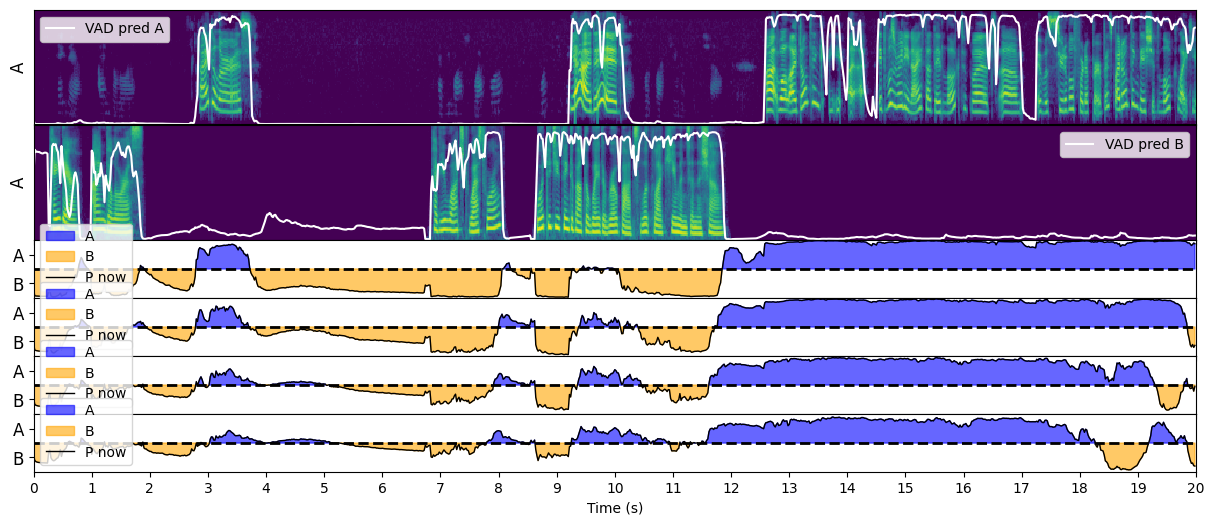

In [5]:
# Plot the output
fig, ax = plot_output(waveform, out)

In [6]:
# Show the plot
plt.show()